In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')

In [ ]:
class Event:
    def __init__(self, time_since_last_trigger_us, timestamp_us, nhits, 
                 digit_pmt_id, digit_charge_pc, total_digit_charge_pc, digit_time_ns, digit_ncrossings, 
                 log_pmt_id, log_charge_pc, total_log_charge_pc, log_time_ns,
                 gaussian_pmt_id, gaussian_charge_pc, total_gaussian_charge_pc, gaussian_time_ns): 
        # Global event data
        self.time_since_last_trigger_us = time_since_last_trigger_us
        self.timestamp_us = timestamp_us
        self.nhits = nhits
        self.total_digit_charge_pc = total_digit_charge_pc # ***BROKEN*** 
        self.total_log_charge_pc = total_log_charge_pc # ***BROKEN*** 
        self.total_gaussian_charge_pc = total_gaussian_charge_pc # USE THIS ONE
        self.trigger_type = None # 0=prompt 1=follower
        self.time_since_last_prompt_trigger_us = None

        # Arrays with PMT information 
        self.digit_pmt_id = digit_pmt_id # id of every pmt hit 
        self.digit_ncrossings = digit_ncrossings # number of crossings for every pmt hit 
        self.digit_time_ns = digit_time_ns # time of first crossing for every pmt hit
        self.digit_charge_pc = digit_charge_pc # ***BROKEN*** total charge for every pmt hit
        self.log_pmt_id = log_pmt_id 
        self.log_charge_pc = log_charge_pc # ***BROKEN*** total charge for every pmt hit 
        self.log_time_ns = log_time_ns 
        self.gaussian_pmt_id = gaussian_pmt_id
        self.gaussian_charge_pc = gaussian_charge_pc
        self.gaussian_time_ns = gaussian_time_ns



    def print(self):
        print("---------------------------------------")
        print(f"                     Timestamp : {self.timestamp_us:.3f} us")
        print(f"       Time since last trigger : {self.time_since_last_trigger_us:.3f} us ")
        print(f"                  Trigger Type : {self.trigger_type}")
        print(f"Time since last prompt trigger : {self.time_since_last_prompt_trigger_us}")
        print(f"                         NHits : {self.nhits}")


class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = []

        # Meta data (non event dependent)
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None
        self.pmt_cable_offset = None

        # Event data
        self.events = []

    # Load data for the run
    def load_files(self, path, nfiles=None):
        path = Path(path)
        files = list(path.glob("*/*.root"))
        for f in files:
            if f"run{self.number}" in f.as_posix():
                self.files.append(f)
        self.files = sorted(self.files, key=lambda x: int(x.stem.split('_')[3].split('.')[0]))
        print(f"Found {len(self.files)} files for run {self.number}")
        if nfiles is not None:
            self.files=self.files[:nfiles]

    # Can open any one of the run files to get this
    def load_meta_data(self):
        f=up.open(self.files[0])
        print(f['output'].keys())
        print(f['meta'].keys())

        self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]

    # Must open all the files (assume events in file are in order - timestamp is just wrong)
    def load_event_data(self):
        last_file_end_timestamp_us = 0 # for continuity across files
        for file in tqdm(self.files, desc=f"Parsing {len(self.files)} files for run {self.number}", colour='green'):
            f=up.open(file)
            print(f"Opening file {file}")

            # Per pmt
            digit_pmt_id = f['output']['digitPMTID'].array(library='ak')
            digit_charge_pc = f['output']['digitCharge'].array(library='ak')
            digit_time_ns = f['output']['digitTime'].array(library='ak')
            digit_ncrossings = f['output']['digitNCrossings'].array(library='ak')
            log_pmt_id = f['output']['fit_pmtid_Lognormal'].array(library='ak')
            log_charge_pc = f['output']['fit_charge_Lognormal'].array(library='ak')
            log_time = f['output']['fit_time_Lognormal'].array(library='ak')
            gaussian_pmt_id = f['output']['fit_pmtid_Gaussian'].array(library='ak')
            gaussian_charge_pc = f['output']['fit_charge_Gaussian'].array(library='ak')
            gaussian_time = f['output']['fit_time_Gaussian'].array(library='ak')

            # Per event
            
            timestamps = f['output']['timestamp'].array(library='ak')
            timestamps = ak.to_numpy(timestamps)
            valid_indices = (timestamps > timestamps[0]) & (timestamps < timestamps[-1])
            timestamp_us = timestamps[valid_indices]
            #timestamp_us = ak.to_numpy(timestamps)

            time_since_last_trigger_us = f['output']['timeSinceLastTrigger_us'].array(library='ak') # Make timestamp using relative trigger times
            time_since_last_trigger_us = ak.to_numpy(time_since_last_trigger_us)  # Convert to NumPy array
            time_since_last_trigger_us[time_since_last_trigger_us > 1e9] = 10000  # Replace large values with 0.01 s

            #timestamp_us = f['output']['timestamp'].array(library='ak')
            #timestamp_us = np.cumsum(time_since_last_trigger_us) + last_file_end_timestamp_us
            #last_file_end_timestamp_us = timestamp_us[-1]
            
            nhits = f['output']['digitNhits'].array(library='ak')
            total_digit_charge_pc = np.sum(digit_charge_pc, axis=1)
            total_log_charge_pc = np.sum(log_charge_pc, axis=1)
            total_gaussian_charge_pc = np.sum(gaussian_charge_pc, axis=1)

            
            # Create event instances
            for i in range(len(nhits)):
                event = Event(
                    time_since_last_trigger_us[i],
                    timestamp_us[i],
                    nhits[i],
                    digit_pmt_id[i],
                    digit_charge_pc[i],
                    total_digit_charge_pc[i],
                    digit_time_ns[i],
                    digit_ncrossings[i],
                    log_pmt_id[i],
                    log_charge_pc[i],
                    total_log_charge_pc[i],
                    log_time[i],
                    gaussian_pmt_id[i],
                    gaussian_charge_pc[i],
                    total_gaussian_charge_pc[i],
                    gaussian_time[i]
                )
                self.events.append(event)

    def reset_trigger_types(self):
        for event in self.events:
            event.trigger_type = None

    def set_trigger_types_with_nhit(self,prompt_nhit_range, follower_nhit_range):
        for event in self.events:
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1 
    
    def set_trigger_types_with_nhit_and_charge(self, prompt_nhit_range, follower_nhit_range, prompt_charge_range):
        for event in self.events:
            # use charge to further distinguish prompts
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1] and prompt_charge_range[0] <= event.total_gaussian_charge_pc < prompt_charge_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1

    def set_trigger_types_with_nhit_and_charge_curve(self):
        def curve(x,a,b,c):
            return np.exp(a*(x+b))+c

        for event in self.events:
            nhit = event.nhits
            charge = event.total_gaussian_charge_pc
            cutoff = curve(nhit,0.022,108,90)
            if nhit>70:
                if charge > cutoff:
                    event.trigger_type = 0
                else:
                    event.trigger_type = 1
            
    def set_time_since_last_promp_trigger(self):
        prompt_time = 0
        for event in self.events:
            if event.trigger_type==0:
                prompt_time = event.timestamp_us
            else:
                event.time_since_last_prompt_trigger_us = event.timestamp_us - prompt_time

    def reset_time_since_last_prompt_trigger(self):
        for event in self.events:
            event.time_since_last_prompt_trigger_us = None
                
    def get_time_since_last_trigger_us(self):
        return [event.time_since_last_trigger_us for event in self.events]

    def get_time_since_last_prompt_trigger_us(self):
        return [event.time_since_last_prompt_trigger_us for event in self.events]

    def get_timestamp_us(self):
        return [event.timestamp_us for event in self.events]
    
    def get_nhits(self):
        return [event.nhits for event in self.events]
    
    def get_digit_pmt_id(self):
        return [event.digit_pmt_id for event in self.events]
    
    def get_digit_charge_pc(self):
        return [event.digit_charge_pc for event in self.events]
    
    def get_total_digit_charge_pc(self):
        return [event.total_digit_charge_pc for event in self.events]
    
    def get_digit_time_ns(self):
        return [event.digit_time_ns for event in self.events]
    
    def get_digit_ncrossings(self):
        return [event.digit_ncrossings for event in self.events]
    
    def get_log_pmt_id(self):
        return [event.log_pmt_id for event in self.events]
    
    def get_log_charge_pc(self):
        return [event.log_charge_pc for event in self.events]
    
    def get_total_log_charge_pc(self):
        return [event.total_log_charge_pc for event in self.events]
    
    def get_log_time_ns(self):
        return [event.log_time_ns for event in self.events]
    


In [3]:
path = '/nfs/disk1/eos/eos-processed-data-nubar/'
nfiles = 1

run = Run(1246)
run.load_files(path,nfiles)
run.load_meta_data()
run.load_event_data()


Found 1157 files for run 1246
['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 'scintEdep', 'scintEdepQuenched', 'scintPhotons', 'remPhotons', 'cherPhotons', 'hitPMTID', 'hitPMTTime', 'hitPMTCharge', 'digitNhits', 'digitPMTID', 'digitTime', 'digitCharge', 'digitNCrossings', 'digitTimeOverThreshold', 'digitVoltageOverThreshold', 'digitPeak', 'digitLocalTriggerTime', 'digitReconNPEs', 'fit_pmtid_Lognormal', 'fit_time_Lognormal', 'fit_charge_Lognormal', 'fit_pmtid_Gaussian', 'fit_time_Gaussian', 'fit_charge_Gaussian', 'fit_pmtid_Sinc', 'fit_time_Sinc', 'fit_charge_Sinc', 'mcPMTID', 'mcPMTNPE', 'mcPMTCharge', 'mcPEPMTID', 'mcPEHitTime', 'mcPEFrontEndTime', 'mcPEProcess', 'mcPEWavelength', 'mcPEx', 'mcPEy', 'mcPEz', 'mcPECharge', 'time_quadfitter', 'x_FitCentroid', 'x_quadfitter', 'y_FitCentroid', 'y_quadfitter', 'z_FitCentroid', 'z_quadfitter

Parsing 1 files for run 1246:   0%|          | 0/1 [00:00<?, ?it/s]

Opening file /nfs/disk1/eos/eos-processed-data-nubar/run1246/eos_run_001246_000.ntuple.root


Parsing 1 files for run 1246:   0%|          | 0/1 [00:01<?, ?it/s]


IndexError: index 8617 is out of bounds for axis 0 with size 8617

2010 prompt triggers found
1210 follower triggers found
5425 bad triggers found
Got 1392205750861.639 s of data
Prompt trigger frequency 0.000 Hz
Follower trigger frequency 0.000 Hz


/tmp/ipykernel_992017/3315380770.py:181: RuntimeWarning: overflow encountered in scalar subtract
  event.time_since_last_prompt_trigger_us = event.timestamp_us - prompt_time


Text(0, 0.5, 'timestamp')

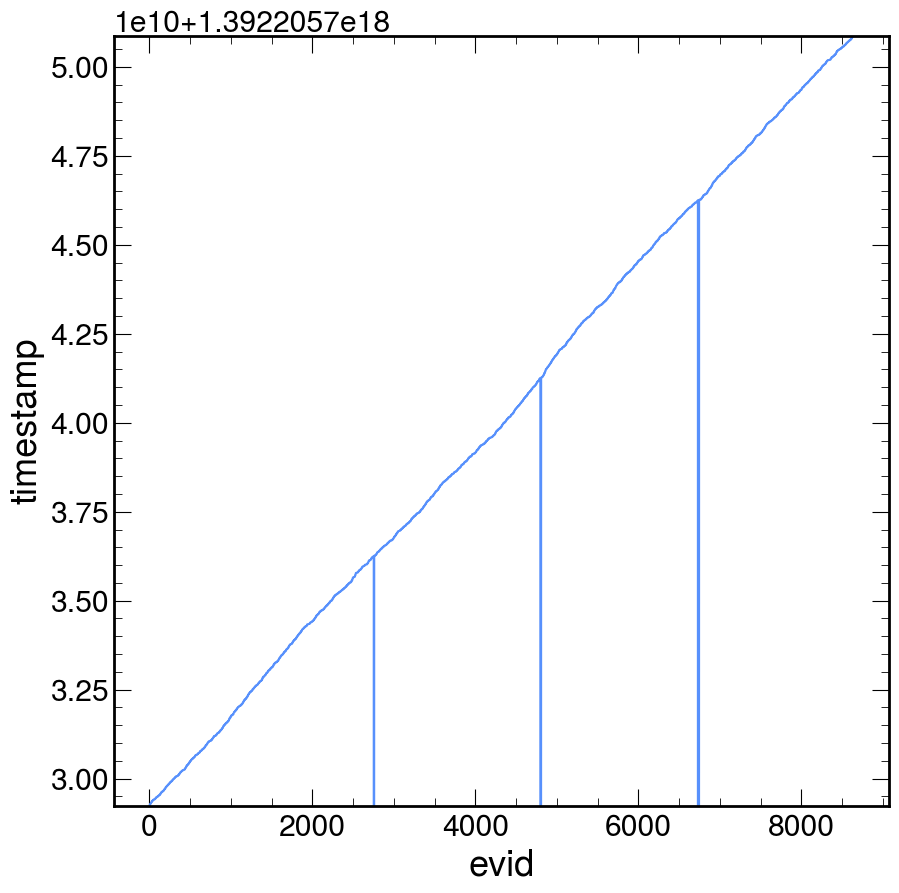

In [ ]:
def line(x,a,b,c):
    return np.exp(a*(x+b))+c

x = np.arange(0,200,1000)



prompt_nhit_range = (170,200)
follower_nhit_range = (70,130)

prompt_charge_range = (600,1500)

run.reset_trigger_types()
run.reset_time_since_last_prompt_trigger()

#run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range)
#run.set_trigger_types_with_nhit_and_charge(prompt_nhit_range, follower_nhit_range, prompt_charge_range)
run.set_trigger_types_with_nhit_and_charge_curve()
run.set_time_since_last_promp_trigger()

nprompt = [event.trigger_type==0 for event in run.events].count(True)
print(f"{nprompt} prompt triggers found")
nfollower= [event.trigger_type==1 for event in run.events].count(True)
print(f"{nfollower} follower triggers found")
nbad = [event.trigger_type==None for event in run.events].count(True)
print(f"{nbad} bad triggers found")

nhits = run.get_nhits()
ts = run.get_timestamp_us()
dt = run.get_time_since_last_trigger_us()
dt_prompt = run.get_time_since_last_prompt_trigger_us()

prescale = 16
print(f"Got {ts[-1]/1e6:.3f} s of data")
print(f"Prompt trigger frequency {16*nprompt/(ts[-1]/1e6):.3f} Hz")
print(f"Follower trigger frequency {nfollower/(ts[-1]/1e6):.3f} Hz")

plt.plot(ts)
plt.ylim(ts[0],ts[-1])
plt.xlabel('evid',loc='center')
plt.ylabel('timestamp',loc='center')

In [ ]:



charge = [event.total_gaussian_charge_pc for event in run.events]
nhit = [event.nhits for event in run.events]

prompt_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]
prompt_nhit = [event.nhits for event in run.events if event.trigger_type==0]

early_follower_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
early_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

late_follower_charge = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]
late_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]


x = np.linspace(0,200,100)


fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout()
hep.hist2dplot(np.histogram2d(nhits, charge, bins=(130,200), range=((70,200),(0,1500))), ax=ax[0], norm='log')
ax[0].set_title("All Triggers")
ax[0].plot(x,line(x,0.022,108,90),'-',linewidth=2,color='red')




hep.hist2dplot(np.histogram2d(prompt_nhit, prompt_charge, bins=(130,200), range=((70,200),(0,1500))), ax=ax[1], norm='log')
ax[1].set_title("Prompt Triggers")
ax[1].set_xlabel("NHits")
ax[1].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(early_follower_nhit, early_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[2], norm='log')
ax[2].set_title("Early Follower Triggers")
ax[2].set_xlabel("NHits")   
ax[2].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(late_follower_nhit, late_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[3], norm='log')
ax[3].set_title("Late Follower Triggers")
ax[3].set_xlabel("NHits")
ax[3].set_ylabel("Charge (pc)")

# Cut on nhit and charge aboce 100 nhit to isolate the three regions
# Top is prompt muons
# Bottoms is early michels
# What is middle? Late something

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7dfa65be7b80> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 1837.56x500 with 7 Axes>

In [ ]:
# early_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us<3]
# late_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us>3]

# ec, eb = np.histogram(early_total_charge, bins=50, range=(0,500))
# lc, lb = np.histogram(late_total_charge, bins=50, range=(0,500))
# res = lc-ec
# centers = (eb[1:]+eb[:-1])/2

# plt.hist(early_total_charge, bins=50, range=(0,500), histtype='step', label='Early - Decaying Muon');
# plt.hist(late_total_charge, bins=50, range=(0,500), histtype='step', label='Late - Crossing Muon');
# plt.plot(centers, res, label='Difference',)
# plt.legend()
# plt.yscale('log')

In [ ]:
# for event in run.events:
#     event.print()


In [ ]:
# nhits = run.get_nhits()

# plt.figure(figsize=(10, 6))
# hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
# plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
# plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
# plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
# #plt.ylim(1e3,1e5)
# plt.yscale('log')
# plt.ylabel('Number of Events', fontsize=20)
# plt.xlabel('Total NHits per Event', fontsize=20)

In [ ]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(29, 30), range=((1, 30), (0,200)), norm='log', cmap='Blues')
ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
ax[1].set_xlim(1,30)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])


In [ ]:
deltat_follower = np.array(deltat_follower)
deltat = np.array(deltat)


plt.figure(figsize=(6, 4))
plt.hist(deltat, bins=19, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=19, range=(1, 20), histtype='step', label='Follower');

In [ ]:

def fit_decay_hist(data,bins=19,range=(0.5,30),tau_guess=2):

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label=fr'WLS Fit: $\tau$ = {tau_fit:.3f} +/- {tau_err:.3f} µs')
    plt.xlabel('$\Delta$T (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(f" $\Delta$T = Time Since Last Prompt Trigger",fontsize=20)
    plt.grid(True)
    #plt.yscale('log')
    #plt.axvspan(0.5,3, color='blue', alpha=0.5, label='Selected Events')
    plt.legend(fontsize=15)
    plt.show()
    

#deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<10]
fit_decay_hist(deltat_follower)



In [ ]:
total_digit_charge_pc = [event.total_digit_charge_pc for event in run.events if event.trigger_type!=None] 
total_log_charge_pc = [event.total_log_charge_pc for event in run.events if event.trigger_type!=None]
total_gaussian_charge_pc = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type!=None]

print(len(total_log_charge_pc),len(total_digit_charge_pc), len(total_gaussian_charge_pc))
print(total_digit_charge_pc[0])
print(total_log_charge_pc[0])
print(total_digit_charge_pc[0])

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),sharey=True,tight_layout=True)
fontsize = 25
bins=150
upper_charge=15000
log_bins = np.logspace(np.log10(1),np.log10(upper_charge), bins)

total_log_charge_pc_follower_early = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_log_charge_pc_follower_late = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_log_charge_pc_prompt = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]

ax[0].hist(total_log_charge_pc_follower_early, bins=log_bins, range=(0,upper_charge), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
ax[0].hist(total_log_charge_pc_follower_late, bins=log_bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
ax[0].hist(total_log_charge_pc_prompt, bins=log_bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[0].set_xlabel('Total Log Charge (pc)', fontsize=fontsize)
ax[0].set_ylabel('Triggers per bin', fontsize=fontsize)
ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_xlim(3e1,1e4)
#ax[0].legend()

total_gaussian_charge_pc_follower_early = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_gaussian_charge_pc_follower_late = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_gaussian_charge_pc_prompt = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]

ax[1].hist(total_gaussian_charge_pc_follower_early, bins=log_bins, range=(0,upper_charge), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
ax[1].hist(total_gaussian_charge_pc_follower_late, bins=log_bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
ax[1].hist(total_gaussian_charge_pc_prompt, bins=log_bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[1].set_xlabel('Total Gaussian Charge (pc)', fontsize=fontsize)
ax[1].set_ylabel('Triggers per bin', fontsize=fontsize)
ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_xlim(3e1,1e4)
#ax[1].legend()

total_digit_charge_pc_follower_early = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_digit_charge_pc_follower_late = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_digit_charge_pc_prompt = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]

ax[2].hist(total_digit_charge_pc_follower_early, bins=log_bins, range=(0,upper_charge), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
ax[2].hist(total_digit_charge_pc_follower_late, bins=log_bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
ax[2].hist(total_digit_charge_pc_prompt, bins=log_bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[2].set_xlabel('Total Digit Charge (pc)', fontsize=fontsize)
ax[2].set_ylabel('Triggers per bin', fontsize=fontsize)
ax[2].set_xlim(3e1,2e4)
ax[2].set_xscale('log')
#ax[2].set_yscale('log')
ax[2].legend(loc='upper left')

In [ ]:

nhit_follower_early = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
nhit_follower_late = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
#nhit_follower_wierd = [event.nhits for event in run.events if event.trigger_type==1 and 8>event.time_since_last_prompt_trigger_us>3]
nhit_prompt = [event.nhits for event in run.events if event.trigger_type==0]

#plt.hist(total_log_charge_pc_follower, bins=50, range=(0,500), histtype='step', label='Follower');
plt.hist(nhit_follower_early, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs)');
plt.hist(nhit_follower_late, bins=50, range=(0,200), histtype='step', label='Late Follower Trigers ($\Delta$T > 4 µs)');
#plt.hist(nhit_follower_wierd, bins=50, range=(0,200), histtype='step', label='Follower Wierd');
plt.hist(nhit_prompt, bins=50, range=(0,200), histtype='step', label='All Prompt Triggers');
plt.xlabel('NHits', fontsize=20)
plt.ylabel('Counts per 4 NHit', fontsize=fontsize)
plt.legend(loc='upper left',fontsize=fontsize)
plt.yscale('log')

In [ ]:
michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_log_charge_pc<120]


charges = [event.total_log_charge_pc for event in michels]

plt.figure(figsize=(8, 6))
hep.histplot(np.histogram(charges, bins=30), color='black', label='Michel Candidates')


In [ ]:
times = [event.digit_time_ns for event in michels]
print(times[0])

plt.figure(figsize=(8, 6))


times = ak.flatten(times) 


plt.hist(times, color='black', bins=500, range=(-200,200), label='Michel Candidates')
plt.yscale('log')

In [ ]:
# Figure out which hits are coming from which channels
print(run.pmt_id)

print(run.pmt_ch)

# Then figure out cable delays for each channels

# Then compare data across boards

In [ ]:

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_early, total_gaussian_charge_pc_follower_early, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Blues', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_late, total_gaussian_charge_pc_follower_late, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Reds', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_prompt, total_gaussian_charge_pc_prompt, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Greens', norm='log')


In [ ]:
nhits = [event.nhits for event in run.events]
charges = [event.total_log_charge_pc for event in run.events]

charge_log_bins = np.logspace(np.log10(2),np.log10(1500), bins)
nhit_log_bins = np.logspace(np.log10(2),np.log10(200), bins)

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(200, 200), range=((0, 200), (0, 1500))), norm='log')
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
early_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<30]
late_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>30]


fit_decay_hist(early_follower_times,bins=29,range=(0.5,30),tau_guess=2)
fit_decay_hist(late_follower_times,bins=30,range=(100,400),tau_guess=200)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 4 < $\Delta$T < 7 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 0.5 < $\Delta$T < 4 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)